## COMP411/511  HW3
### Deadline: 22 December 2024, 23.59 

You have **TODOs** in this code. They are all marked with `TODO` in comments.  
Your task is to fill them in with the correct code. Do **not** change any other code.  

You also have some questions to answer. They are marked with `QA` as markdown cells.  

---

## Parts:

### **1: Classification on CIFAR**
1.1: **Simple CNN** *(10 pts)*  
1.2: **Deeper CNN** *(10 pts)*  
1.3: **Regularized Deeper CNN** *(10 pts)*  
1.4: **QA** *(5 pts)*  

---

### **2: Semantic Segmentation on Pascal VOC**
2.1.1: **Preprocess Pascal VOC** *(5 pts)*  
2.1.2: **QA** *(5 pts)*  
2.2: **Pretrained FCN** *(20 pts)*  
2.3: **QA** *(15 pts)*  
2.4: **Training the FCN** *(20 pts)*  

---

### **Total: 100 points**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

## Part 1: Classification on CIFAR

In [2]:
NUM_TRAIN = 49000
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./datasets', train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def check_accuracy_and_loss(loader, model, device): 
    acc = 0
    total_loss = 0
    model.eval()
    num_correct = 0
    num_samples = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)
            total_loss += loss
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = num_correct / num_samples
    total_loss /= len(loader)
    return acc, total_loss

# Part 1.1: Simple CNN (10 pts)

In [4]:
# TODO: Define a simple CNN with the following architecture:
#
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=3, output_channel=32)
# ReLU
# MaxPool(kernel=2, stride=2)
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=32, output_channel=64)
# ReLU
# MaxPool(kernel=2, stride=2)
# Flatten   
# Linear(input=64*8*8, output=10)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # === TODO ===
        # First conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*8*8, 10)
        # === === ===

    def forward(self, x):
        # === TODO ===
        #print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        #print("x after first conv layer: ", x.shape)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        #print("x after second conv layer: ", x.shape)
        
        x = torch.flatten(x, start_dim=1) # if shape is [a, b, c, d], then start_dim=1 means flatten from b to d. This way we don't flatten batches.
        x = self.fc(x)
        #print("x after fully connected layer: ", x.shape)
        # === === ===
        return x

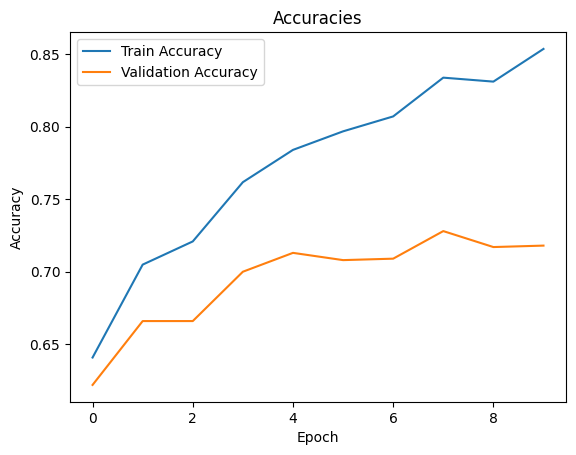

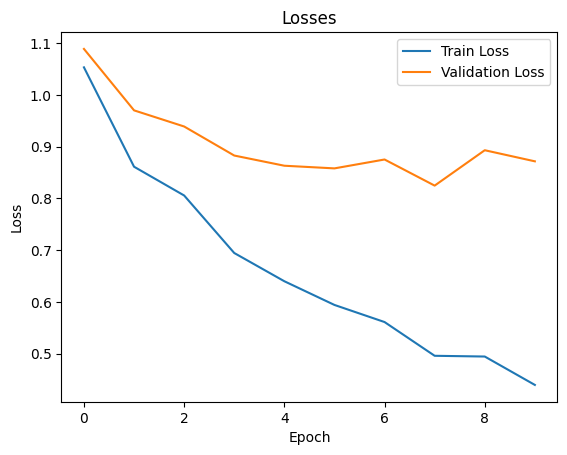

In [5]:
# TODO: Train the model with 
#           Adam optimizer
#           Learning rate of 1e-3
#           Batch size of 64
#           10 epochs
#           Cross Entropy Loss
# Check train loss and train accuracy after each epoch, and validate accuracy after each epoch
# Store them, and plot them at the end
# Moreover, store losses and plot them at the end
# You should be easily able to achieve >65% accuracy on the validation set


lr = 1e-3
epochs = 10

model = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    for x, y in loader_train:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
    val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot([i.cpu() for i in train_accs], label='Train Accuracy')
plt.plot([i.cpu() for i in val_accs], label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot([i.cpu() for i in train_losses], label='Train Loss')
plt.plot([i.cpu() for i in val_losses], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Part 1.2: Deeper CNN (10 pts)

In [6]:
# TODO: Now, implement a deeper CNN with the following architecture:
#
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=3, output_channel=32)
# ReLU
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=32, output_channel=32)
# ReLU
# MaxPool(kernel=2, stride=2)
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=32, output_channel=64)
# ReLU
# Conv(kernel=(3, 3), stride=1, padding=1, input_channel=64, output_channel=64)
# ReLU
# MaxPool(kernel=2, stride=2)
# Flatten
# Linear(input=64*8*8, output=128)


class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        # === TODO ===
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu4 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
        # === === ===

    def forward(self, x):
        # === TODO ===
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
    
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        
        x = self.pool2(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.fc2(x)
        # === === ===
        return x



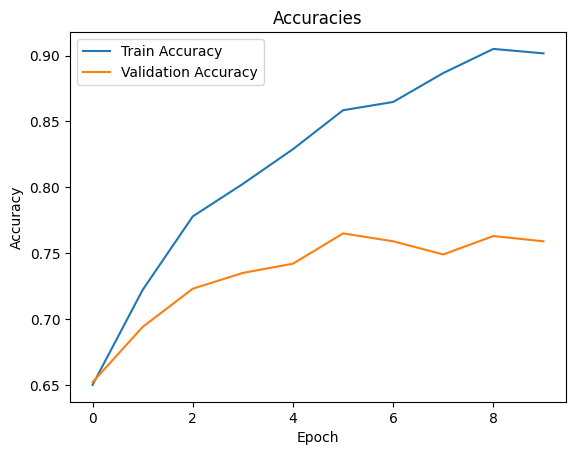

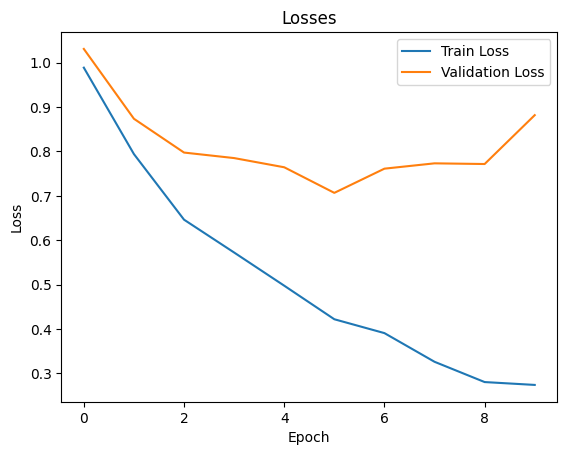

In [7]:
# Train the model with the same configuration as before
# You should be easily able to achieve >70% accuracy on the validation set

lr = 1e-3
epochs = 10

model = DeepCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    for x, y in loader_train:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
    val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot([i.cpu() for i in train_accs], label='Train Accuracy')
plt.plot([i.cpu() for i in val_accs], label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot([i.cpu() for i in train_losses], label='Train Loss')
plt.plot([i.cpu() for i in val_losses], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Part 1.3: Regularized Deeper CNN (10 pts)

In [8]:
# TODO: We observe an overfitting in the training and validation losses. The training loss is decreasing while the validation loss is increasing. This is a clear sign of overfitting.
#       In this part, your task is to solve this problem by adding dropout layers and batch normalization layers to each layer of the model.
#       You should add dropout and batch normalization layers to proper places (https://jmlr.org/papers/v15/srivastava14a.html)


class RegDeepCNN(nn.Module):
    def __init__(self):
        super(RegDeepCNN, self).__init__()
        # === TODO ===
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.dropout2 = nn.Dropout(0.6)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.6)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu4 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.dropout4 = nn.Dropout(0.6)
        
        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
        # === === ===

    def forward(self, x):
        # === TODO ===
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout4(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.fc2(x)
        # === === ===
        return x

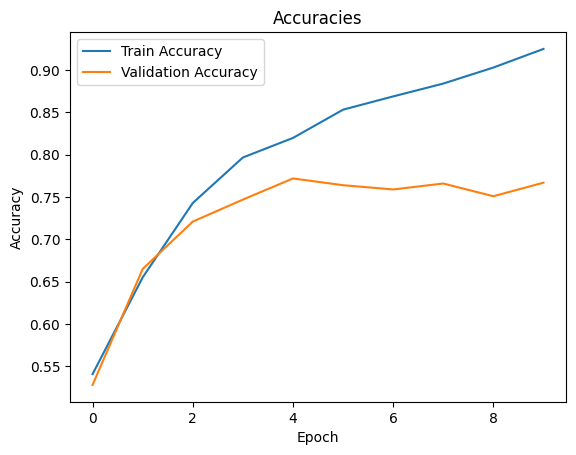

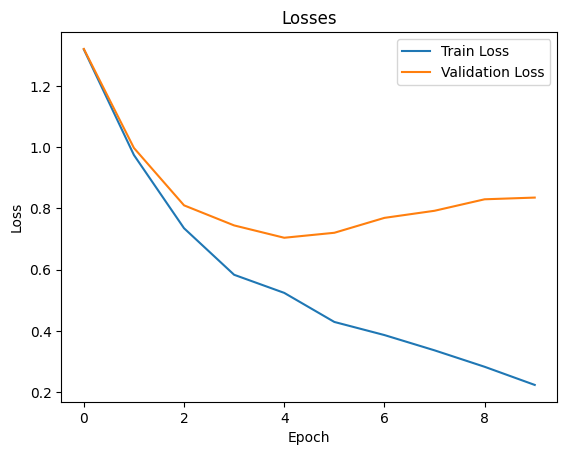

In [9]:
# Train the model with the same configuration as before

lr = 1e-3
epochs = 10

model = RegDeepCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    for x, y in loader_train:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
    val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot([i.cpu() for i in train_accs], label='Train Accuracy')
plt.plot([i.cpu() for i in val_accs], label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot([i.cpu() for i in train_losses], label='Train Loss')
plt.plot([i.cpu() for i in val_losses], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Part 1.4: QA (5 pts)
Q1: Dit it solve overfitting? Explain why or why not. (3 pts)

A: Well in my case it didn't. I first tried setting the overfitting chance to 0.5, after still seeing a large amount of overfitting (20% diff between test and validation), I increased it to 0.7. I think this made the model too shallow and lack too many connections because the test error didn't decrease compared to previous models. I then thought to myself that normalizing the first layer could be a bad idea because it felt like normalizing the first layer could induce a lot of information loss (a guess based on blind intuition), I then decreased the p parameter from 0.7 to 0.3 on the first and last CNN layer. Leaving the middle two CNN layers with 0.7 p, this increased the validation accuracy quite a lot, to 95%+, but it didn't help test accuracy much, the test accuracy peaks at around 75% at the 7th epoch and doesn't increase.

Why?
I'm not very sure, but I'm guessing that using a single method of regularization is not enough due to various reasons, perhaps factors such as data quality and low diversity are the reason.

---

Q2: What else can you do to solve overfitting? 

Hint: One option could be a different kind of optimizer, check PyTorch documentation (2 pts)

A: AdamW seems to have an option for regularization, I tested it below. I suppose we could also use SGD with L2 regularization.
Using weight_decay=5e-1 in AdamW also minimizes the validation test accuracy gap, but the test accuracy doesn't increase by much.

## Part 2: Semantic Segmentation on Pascal VOC

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from PIL import Image

## Part 2.1.1: Preprocess Pascal VOC (5 pts)

In [11]:

# TODO: Define transformations for both image and mask
# Resize the image to 256x256 with interpolation mode with proper kind of interpolation
# Resize the mask to 256x256 with interpolation mode with proper kind of interpolation
# Convert the image to tensor
# Convert the mask to tensor

class SegmentationTransform:
    def __init__(self, size=(256, 256)):
        # === TODO ===
        self.image_transform = T.Compose([
            T.ToTensor(),
            T.Resize(size, interpolation=Image.BICUBIC),
            # Mean and std calculated using below code
            T.Normalize(mean=torch.tensor([0.4568, 0.4409, 0.4047]), std=torch.tensor([0.2310, 0.2271, 0.2327]))
        ])
        # === === ===

        # === TODO ===
        self.mask_transform = T.Compose([
            T.ToTensor(),
            T.Resize(size, interpolation=Image.NEAREST)
        ])
        # === === ===

    def __call__(self, img, mask):
        img = self.image_transform(img)
        mask = self.mask_transform(mask).squeeze(0)  # Remove channel dim
        return img, mask
    
# Dataset with consistent transforms
transform = SegmentationTransform()

# Load Pascal VOC dataset
train_dataset = VOCSegmentation(
    root='./datasets',
    year='2012',
    image_set='train',
    download=True,
    transforms=transform
)

val_dataset = VOCSegmentation(
    root='./datasets',
    year='2012',
    image_set='val',
    download=True,
    transforms=transform
)

voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

assert len(train_dataset) == 1464
assert len(val_dataset) == 1449
assert train_dataset[0][0].shape == (3, 256, 256)
assert train_dataset[0][1].shape == (256, 256)




Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


In [12]:
# Calculate mean and std of the dataset

def calculate_mean_std(dataset):
    mean = 0.
    std = 0.
    for i in range(len(dataset)):
        img = dataset[i][0]
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std
train_mean, train_std = calculate_mean_std(train_dataset)
val_mean, val_std = calculate_mean_std(val_dataset)

avg_mean = (train_mean + val_mean) / 2
avg_std = (train_std + val_std) / 2
avg_mean, avg_std

(tensor([ 2.0829e-04,  3.8259e-05, -4.9363e-05]),
 tensor([0.9999, 0.9999, 0.9998]))

# Part 2.1.2: QA (5 pts)

 Q: Which interpolation did you prefer for image and mask resizing? Can you use bilinear interpolation for masks?

 A: I decided to use bicubic for the image interpolation because it provides the most smoothness and looks the most natural (compared to bilinear).
 We can't use bilinear or bicubic in masks because we can't have any "smooth" pixels, each pixel must belong to a distinct class and thats why we have to use Nearest interpolation. This interpolation looks at the closest pixel and just uses it, this way there can't be any newly introduced pixels (new colors).



## Part 2.2: Pretrained FCN (20 pts)

In [13]:
# TODO: Segmentation can be considered as a pixel-wise classification problem. 
#       Fully Convolutional Network (https://arxiv.org/pdf/1411.4038) is a popular architecture for semantic segmentation, classifying each pixel in an image, to a class.
#       In this part, you are going to use pretrained Fully Convolutional Network (FCN) for semantic segmentation.
#       You can use the torchvision.models.segmentation.fcn_resnet50 model for this task, which is a FCN model with a ResNet-50 backbone.
#       You should use the pretrained weights of the model.
#       IMPORTANT: Tthe output of the model is a dictionary with key 'out' which contains the output of the model.
#
#       You should also implement the compute_mIoU function that computes the mIoU for a given model and dataloader.
#
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = torchvision.models.segmentation.fcn_resnet50(pretrained=True).requires_grad_(False).to(DEVICE)

# 10 pts
def compute_mIoU(model, dataloader, num_classes=21):
    # === TODO ===
    model.eval()  # Set the model to evaluation mode
    iou_values = torch.zeros(num_classes).to(DEVICE)  # To store IoU for each class
    total_pixels = torch.zeros(num_classes).to(DEVICE)  # To count valid pixels per class
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            output = model(images)['out']
            predictions = torch.argmax(output, dim=1)  
            
            # Compute IoU for each class
            for c in range(num_classes):
                intersection = ((predictions == c) & (masks == c)).sum().float()
                union = ((predictions == c) | (masks == c)).sum().float()
                
                if union > 0:
                    iou_values[c] += intersection / union  # Add IoU for this batch
                total_pixels[c] += (masks == c).sum().float()  # Count valid pixels for this class
    
    # Average IoU across batches for each class
    valid_classes = total_pixels > 0  # Only consider classes with non-zero pixels
    miou = iou_values[valid_classes].mean().item()  # Compute mean IoU for valid classes
    # === === ===
    return miou


val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
miou = compute_mIoU(model, val_loader, num_classes=21)

# You should be able to achieve mIoU ~0.72 with the pretrained model
print(f'mIoU: {miou:.4f}')

/var/home/gabechu/miniconda3/envs/edf/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/home/gabechu/miniconda3/envs/edf/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mIoU: 81.9420


Starting plotting...


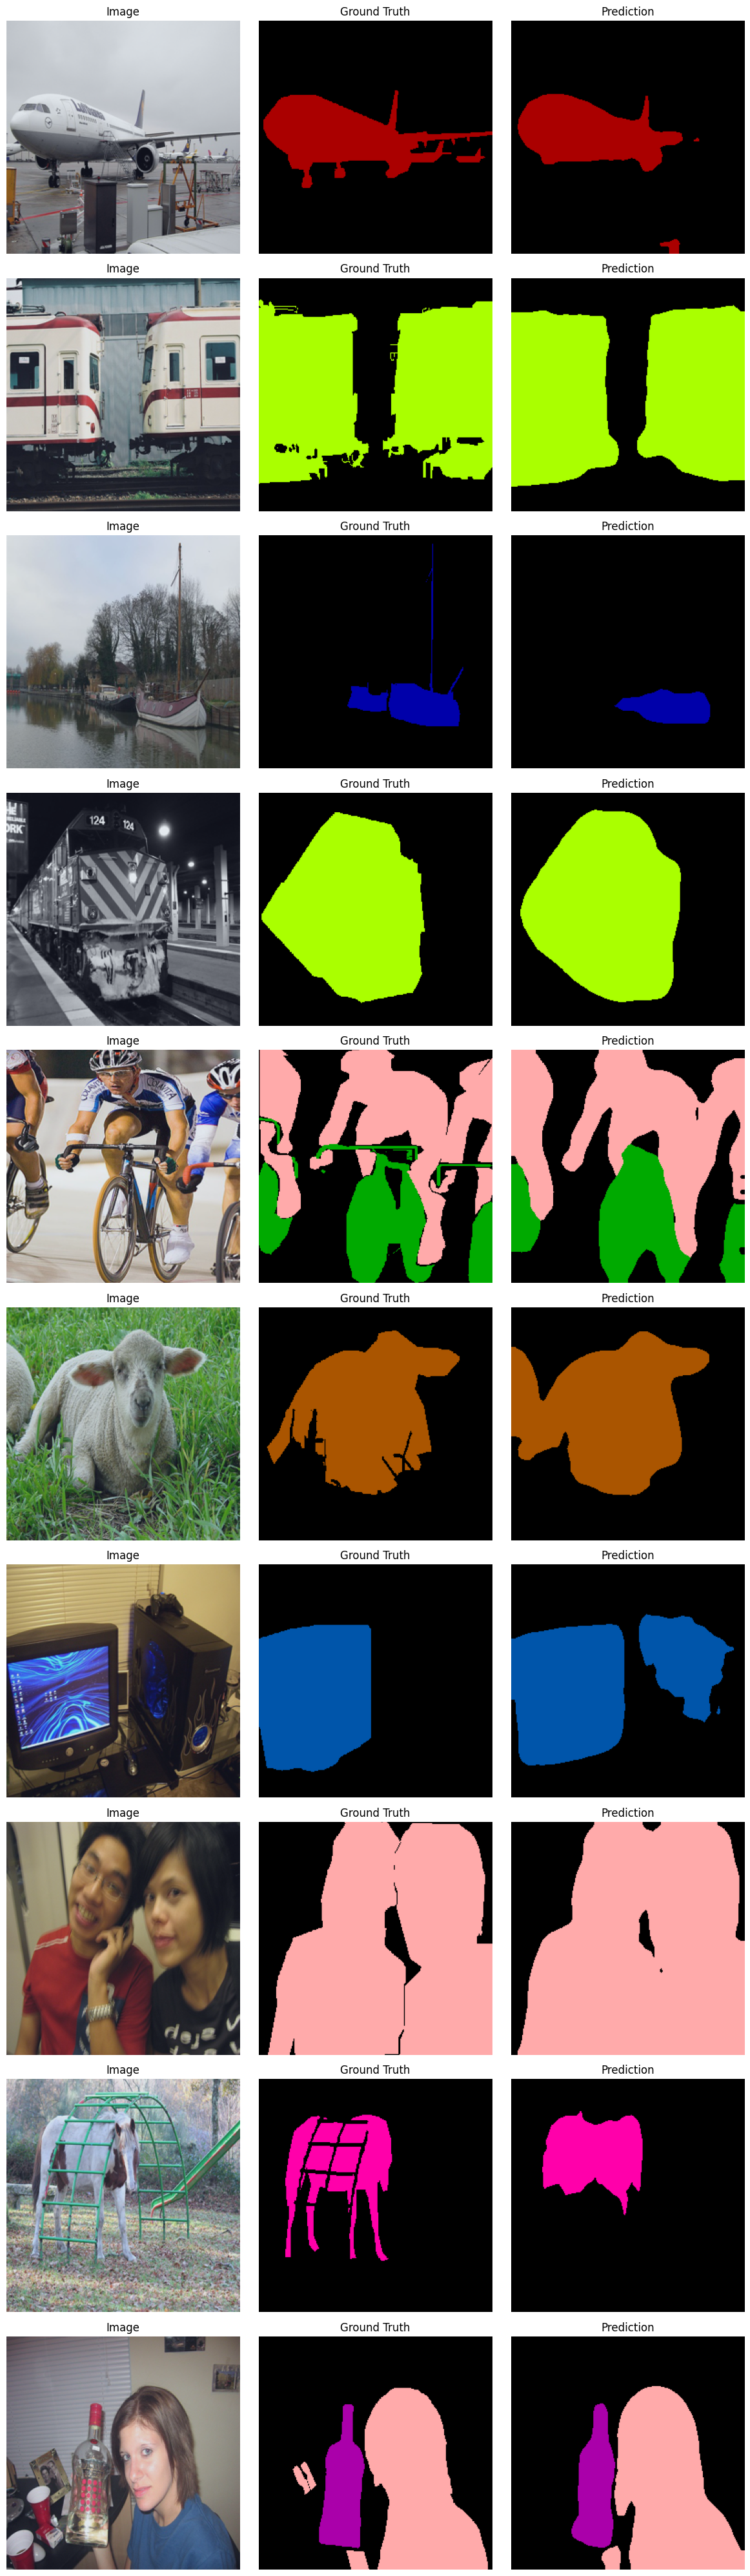

In [14]:
# TODO: Now, provided class to color mapping below, you should visualize the predictions of the model on the validation set.
#       For your convenience, the VOC color map is provided below.
#       You should display 10 images with their original, ground truth, and predicted images side by side. The output should be similar to the example below.


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


# 10 pts
def visualize_predictions_with_voc_colors(model, dataloader, num_images, num_classes=21):
    # === TODO ===
    def transform_image(img):
        # [batch_size, 3, 256, 256] -> [batch_size, 256, 256, 3]
        if len(img.shape) == 4 and img.shape[1:] == (3, 256, 256):
            img = img.permute(0, 2, 3, 1)
        # [3, 256, 256] -> [256, 256, 3]
        elif len(img.shape) == 3 and img.shape == (3, 256, 256):
            img = img.permute(1, 2, 0)
        
        # Normalize the tensor to range [0, 1]
        return (img - img.min()) / (img.max() - img.min())

    def denormalize_mask(tensor) -> torch.Tensor:
        # Ensure tensor has the correct shape
        assert tensor.shape[1:] == (256, 256) or tensor.shape == (256, 256)
        tensor[tensor == 1] = 0 # Remove background
        return (tensor*257).int()

    def apply_colormap(mask: torch.Tensor, colormap: torch.Tensor) -> torch.Tensor:
        if mask.shape[1:] == (256, 256):
            return colormap[mask].permute(0, 3, 1, 2)
        elif mask.shape == (256, 256):
            return colormap[mask].permute(2, 0, 1)
        else:
            raise ValueError("Invalid shape, must be either (256, 256) or (batch_size, 256, 256)")
    dataloader = iter(dataloader)
    images, masks = next(dataloader)  # Load one batch
    while len(images) < num_images:
        new_images, new_masks = next(dataloader)
        images = torch.cat([images, new_images], dim=0)
        masks = torch.cat([masks, new_masks], dim=0)
    
    images, masks = images[:num_images].to(DEVICE), masks[:num_images].to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        outputs = model(images)['out'] # [batch_size, 21, 256, 256]
        predictions = torch.argmax(outputs, dim=1)
    
    
    # Plotting
    images = transform_image(images)
    tensor_colormap = torch.tensor(VOC_COLORMAP, dtype=torch.uint8).cpu()
    masks = transform_image(apply_colormap(denormalize_mask(masks).cpu(), tensor_colormap))
    predictions = transform_image(apply_colormap(predictions.cpu(), tensor_colormap))
    
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    axes = axes.reshape(num_images, 3)
    
    print("Starting plotting...")
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].cpu())
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')
        
        # Plot ground truth mask
        axes[i, 1].imshow(masks[i].cpu())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        # # Plot prediction mask
        axes[i, 2].imshow(predictions[i])
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    # === === ===

visualize_predictions_with_voc_colors(model, val_loader, num_images=10)

# Part 2.3: QA (15 pts)
Read the "Fully Convolutional Networks for Semantic Segmentation" paper (https://arxiv.org/abs/1411.4038) in detail, and answer the following questions:

Q: How does the “skip architecture” improve semantic segmentation results compared to the baseline FCN models?

A: "It combines coarse, semantic and local, apperenace information to refine predictions." [Direct quote] The results are improved segmentation accuracy, especially at object boundaries.

---

Q: What are the trade-offs between the “shift-and-stitch” method and in-network upsampling for producing dense predictions?

A: Shift-and-stitch gives more precise results but is slow and redundant. In-network upsampling is faster and simpler but less detailed initially.

---

Q: Why does the paper emphasize fine-tuning pre-trained classification networks for semantic segmentation instead of training from scratch?

A: Pre-trained networks learn features from large datasets, making training faster and more accurate when labeled data is limited.

---

Q: Explain the rationale and implementation of “deconvolution layers” for upsampling in the context of the FCN architecture.

A: Deconvolution layers upsample feature maps to the input resolution by learning to restore spatial detail lost during pooling.

---

Q: How does the combination of in-network upsampling and skip connections balance the inherent trade-off between semantic abstraction and spatial precision in fully convolutional networks?

A: In-network upsampling restores resolution, while skip connections add spatial details, which balances context and precision.


## Part 2.4: Training the FCN (20 pts)

In [15]:
# TODO: Now, you are going to train the model on the Pascal VOC dataset from scratch, using the same architecture as before.
#    You should set the pretrained weights of the model to False. The rest of the configuration should be the same.
#    You should set the training configuration by experimenting with different hyperparameters.
#    You should set the batch size, learning rate, optimizer, scheduler, and loss function.
#    Note that, you need to use the CrossEntropyLoss for this task, and ignore the index 255 in the loss calculation. Index 255 represents the 'none' class in the dataset.
#    However, DO NOT train the model for more than 20 epochs.
#    Below, we provided the training procedure outputs for a training of 20 epochs.
#    You should plot the training loss and validation mIoU at the end.
#    You should also visualize the predictions of the model on 6 images from the validation set for every epochs, to observe the training progress.
#    After training, you should be able to achieve a validation mIoU of >0.50.

# === TODO ===
epochs = 20
batch_size = 16
lr = 1e-4
model = torchvision.models.segmentation.fcn_resnet50(weights=None).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# I'm guessing that ignore index 255 corresponds to the background class and therefore
# we should ignore index 0. Because there is not difference between ignore_index=255 and ignore_index=None.
criterion = nn.CrossEntropyLoss(ignore_index=255)
# My assumption was incorrect, apperently index 255 is for the unlabeled pixels and not the background.

def denormalize_mask(tensor) -> torch.Tensor:
    # Ensure tensor has the correct shape
    assert tensor.shape[1:] == (256, 256) or tensor.shape == (256, 256)
    tensor[tensor == 1] = 0 # Remove background
    return (tensor*257).int()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
num_classes = train_loader.dataset[0][1].max().item() + 1



train_losses = []
val_mious = []

for epoch in range(epochs):
    # === TODO ===
    model.train()
    train_loss = 0
    for images, masks in train_loader: # Get one batch
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        masks = denormalize_mask(masks).long()
        prediction = model(images)['out'] # logits
        # print("Preds:", prediction.unique())
        # print("Masks: ", masks.unique())
        loss = criterion(prediction, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    train_losses.append(train_loss / len(train_loader))
    val_mious.append(compute_mIoU(model, val_loader))
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_losses[-1]:.4f}, Validation mIoU: {val_mious[-1]:.4f}")
    visualize_predictions_with_voc_colors(model, val_loader, num_images=6)
    torch.cuda.empty_cache()
    plt.clf()
    plt.close()
    # === === ===


epochs = len(train_losses)
plt.figure(figsize=(12, 5))

# Plot Train Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Validation mIoU
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_mious, label='Validation mIoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 84.00 MiB. GPU 0 has a total capacity of 7.68 GiB of which 73.12 MiB is free. Process 72526 has 2.77 GiB memory in use. Including non-PyTorch memory, this process has 4.80 GiB memory in use. Of the allocated memory 4.36 GiB is allocated by PyTorch, and 259.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

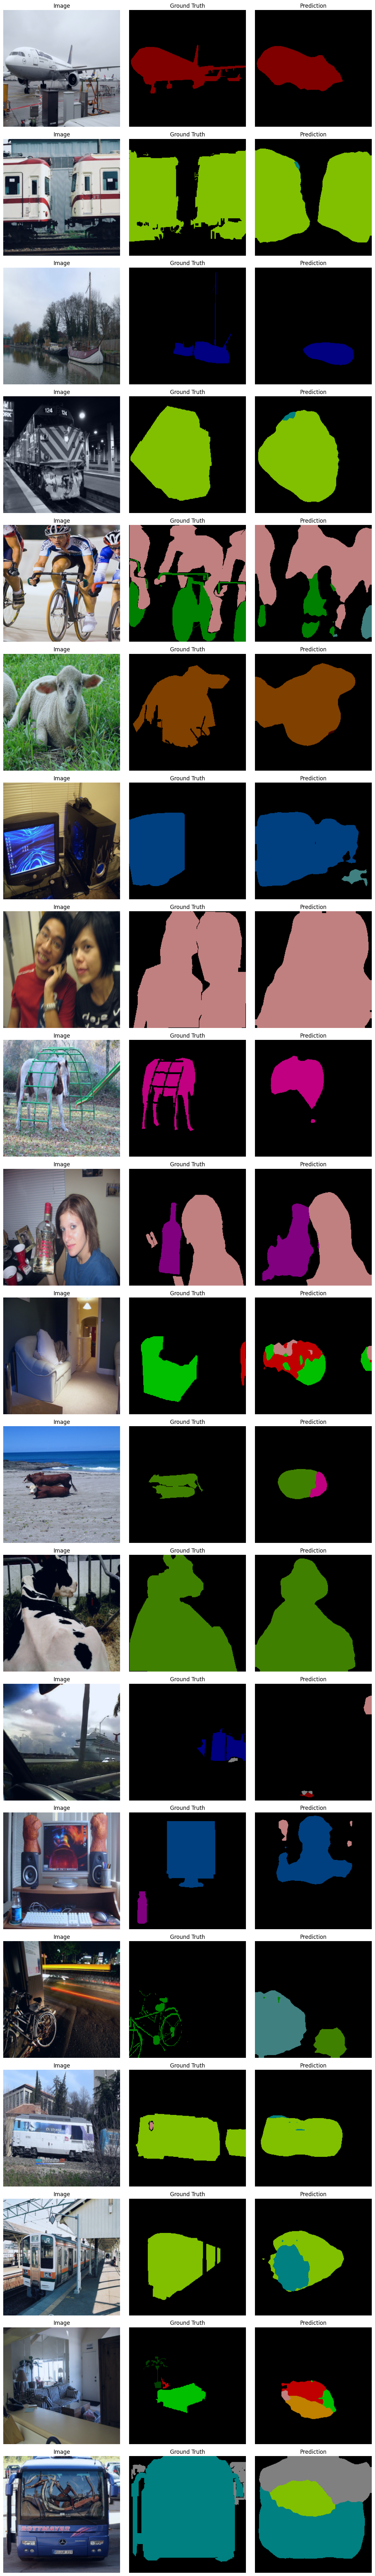

In [20]:
# Now, display 20 images from the validation set with their original, ground truth, and predicted images side by side, using the trained model.
visualize_predictions_with_voc_colors(model, val_loader, num_images=20)